In [1]:
#from sam2.sam2_image_predictor import SAM2ImagePredictor
#print(dir(sam2))
#from sam2.sam2_image_predictor import SAM2ImagePredictor
#from sam2.build_sam import build_sam2
#from sam2.sam2_image_predictor import SAM2ImagePredictor

#from transformers import Owlv2Processor, Owlv2ForObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
from config import topview_vec, sideview_vec, tcp_X_offset, tcp_Y_offset, tcp_Z_offset, n_depth_samples, vit_thresh, tower
# sys.path.append("../")
import numpy as np
from magpie_control import realsense_wrapper as real
from magpie_control.ur5 import UR5_Interface as robot
from Observation import observation
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import time
import os

import random
from openai import OpenAI

from control_scripts import goto_vec, get_pictures, get_frames
from gpt_planning import get_task_interpretation, get_gpt_next_instruction, print_json

sys.path.append("../")
sys.path.append("/home/emerson/THESIS/magpie_control/src")
from APIKeys import API_KEY

import torch


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
OWL_model_name = "google/owlvit-large-patch14" #vit model to use for bounding boxes
class OWLv2:
    def __init__(self):
        self.processor = OwlViTProcessor.from_pretrained(OWL_model_name)
        self.model = OwlViTForObjectDetection.from_pretrained(OWL_model_name)

        self.model.to(torch.device("cuda")) if torch.cuda.is_available() else None
        self.model.to(torch.device("mps")) if torch.backends.mps.is_available() else None
        self.model.eval()  # set model to evaluation mode
    def predict(self, img, querries):
        """
        Gets realsense frames
        Parameters:
        - img: image to produce bounding boxes in
        - querries: list of strings whos bounding boxes we want

        Returns:
        - highest_score_boxes: list of bounding boxes associated with querries
        """
        inputs = self.processor(text=querries, images=img, return_tensors="pt")
        inputs.to(torch.device("cuda")) if torch.cuda.is_available() else None
        inputs.to(torch.device("mps")) if torch.backends.mps.is_available() else None

        with torch.no_grad():
            outputs = self.model(**inputs)
        target_sizes = torch.tensor([img.shape[:2]])  # (height, width)

        results = self.processor.post_process(outputs=outputs, target_sizes=target_sizes)[0]
        #print(f"\n\n{results}\n\n")
        scores = results["scores"]
        labels = results["labels"]
        boxes = results["boxes"]
        unique_classes = torch.unique(labels)

        highest_score_boxes = []

        # Find the highest score box for each class
        for cls in unique_classes:
            # Get indices of the current class
            class_indices = (labels == cls).nonzero(as_tuple=True)[0]
            #print(f"{class_indices=}")
            
            # Get scores for the current class
            class_scores = scores[class_indices]
            #print(f"{class_scores=}")

            
            # Find the index of the maximum score
            max_score = torch.max(class_scores)
            max_index = class_indices[class_scores == max_score]
            #print(f"{max_score=}")
            #print(f"{max_index=}")
            
            #print(f"{boxes[max_index]=}")
            best_bbox = boxes[max_index].tolist()
            #print(f"{best_bbox=}")
            # Get the corresponding box and score
            highest_score_boxes.append((querries[int(cls)], best_bbox, max_score))
        for obj, bbox, score in highest_score_boxes:
            print(f"Detected '{obj}' with confidence {score:.2f} at {bbox}")
        return highest_score_boxes

    def __str__(self):
        return f"OWLv2: {self.model.device}"
    def __repr__(self):
        return self.__str__()
label_vit = OWLv2()

In [3]:
myrs = real.RealSense()
myrs.initConnection()
myrobot = robot()
print(f"starting robot from nb")
myrobot.start()


#print(dir(label_vit.model))
print(f"{label_vit.model.device=}")

sam_predictor = None#SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")
print(f"{sam_predictor=}")

client = OpenAI(
        api_key= API_KEY,
    )


starting robot from nb
Found Dynamixel Port:
/dev/ttyACM0

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 
label_vit.model.device=device(type='cuda', index=0)
sam_predictor=None


In [4]:
myrobot.open_gripper()


Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [5]:
def topview_pick_place_Observations(UR_Interface, rs_wrapper, pick_str, place_str, display= False):
    #print(place_str)
    #initlize local variables
    goto_vec(UR_Interface, topview_vec)
    pick_obs, place_obs = observation(str_label = pick_str) , observation(str_label=place_str)
    pick_obs.update_observation(rs_wrapper, label_vit, sam_predictor, topview_vec, display=True)
    place_obs.update_observation(rs_wrapper, label_vit, sam_predictor, topview_vec, display=True)
    return pick_obs, place_obs



In [6]:
def pick(UR_interface, obs):
    X, Y, Z = obs.ImgFrameWorldCoord
    print(f"Camera Frame Coordinates of Block: {X=}, {Y=}, {Z=}\n")
    new_X = topview_vec[0] - Y + tcp_X_offset
    new_Y = topview_vec[1] - X + tcp_Y_offset
    new_Z = topview_vec[2] - Z + tcp_Z_offset - obs.sidelength
    
    success = True
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y
    success = goto_vec(UR_interface, goal_vec)

    goal_vec[2] = new_Z
    success = goto_vec(UR_interface, goal_vec)
    #print(goal_vec)
    #UR_interface.disconnect()
    #input()

    UR_interface.close_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    success = goto_vec(UR_interface, goal_vec)
    return success

#pick(myrobot, myrs, pick_bb, display = True)

In [7]:
def place(UR_interface, obs):
    X, Y, Z = obs.ImgFrameWorldCoord
    print(f"Camera Frame Coordinates of Block: {X=}, {Y=}, {Z=}\n")
    new_X = topview_vec[0] - Y + tcp_X_offset
    new_Y = topview_vec[1] - X + tcp_Y_offset
    new_Z = topview_vec[2] - Z + tcp_Z_offset
    #if "table" in bb["strlabel"]:
    #    new_X += random.uniform(-0.05, 0.05)
    #    new_Y += random.uniform(0, 0.05)

    

    success = True
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y
    success = goto_vec(UR_interface, goal_vec)

    goal_vec[2] = new_Z
    success = goto_vec(UR_interface, goal_vec)


    UR_interface.open_gripper()
    time.sleep(2)

    goal_vec[2] = topview_vec[2]
    success = goto_vec(UR_interface, goal_vec)

    return success


No LLM PLANNING

In [8]:
"""
#myrobot.stop()
#myrs.disconnect()
#tower = ["red block", "blue block", "green block", "yellow block", "purple block", "orange block"]
temp_tower = [ "yellow block", "blue block", "green block"]#, "green block"]
#tower = ["yellow block", "red block"]
for i in range(0, len(temp_tower)-1):
     pick_str = temp_tower[i+1]
     place_str = temp_tower[i]
     pick_obs, place_obs = topview_pick_place_Observations(myrobot, myrs, pick_str, place_str, display=True)
     pick(myrobot, pick_obs)
     place(myrobot, place_obs)

"""

'\n#myrobot.stop()\n#myrs.disconnect()\n#tower = ["red block", "blue block", "green block", "yellow block", "purple block", "orange block"]\ntemp_tower = [ "yellow block", "blue block", "green block"]#, "green block"]\n#tower = ["yellow block", "red block"]\nfor i in range(0, len(temp_tower)-1):\n     pick_str = temp_tower[i+1]\n     place_str = temp_tower[i]\n     pick_obs, place_obs = topview_pick_place_Observations(myrobot, myrs, pick_str, place_str, display=True)\n     pick(myrobot, pick_obs)\n     place(myrobot, place_obs)\n\n'

YES LLM PLANNING

In [9]:
def create_next_directory(base_dir):
    # List all subdirectories in the base directory
    subdirectories = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
    
    # Extract the numeric part of the directory names (e.g., 'run_0', 'run_1')
    subdirectories = [d for d in subdirectories if d.startswith('run_')]
    subdirectories = [int(d.split('_')[1]) for d in subdirectories if d.split('_')[1].isdigit()]
    
    # If there are no subdirectories, start from 0, else find the max and add 1
    next_dir = max(subdirectories, default=-1) + 1

    # Create the new directory with the name 'run_<next_dir>'
    next_dir_path = os.path.join(base_dir, f"run_{next_dir}")
    os.makedirs(next_dir_path, exist_ok=True)
    
    return next_dir_path

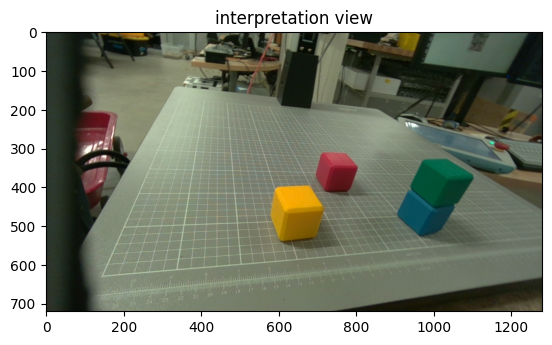

TASK INTERPRETATION: Stack the yellow cube on top of the pink cube.


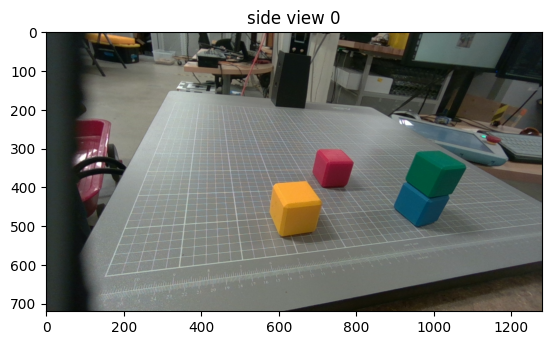

start_state={'yellow block': 'table', 'red block': 'table', 'green block': 'blue block', 'blue block': 'table'}
end_state={'green block': 'blue block', 'yellow block': 'green block', 'red block': 'yellow block'}
prompt='\nGiven the start state:\n   yellow block is on table\n   red block is on table\n   green block is on blue block\n   blue block is on table\n\nand desired end state:\n   green block is on blue block\n   yellow block is on green block\n   red block is on yellow block\n\nwhat is the next best move to get us closer to the end state from the start state? Your answer needs to have two parts on two seperate lines.\n   pick: *object to be picked up*\n   place: *object to put the picked object on*\n\nif there is no block to move please have\n   pick: None\n   place: None\n    '
state={
    "objects": [
        "table",
        "yellow block",
        "red block",
        "green block",
        "blue block"
    ],
    "object_relationships": [
        [
            "yellow block

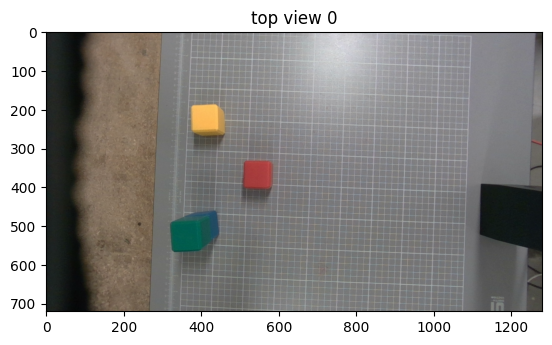

/home/emerson/miniconda3/lib/python3.10/site-packages/transformers/models/owlvit/image_processing_owlvit.py:432: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.
  warnings.warn(


Detected 'yellow block' with confidence 0.19 at [[375.883544921875, 185.02593994140625, 464.20556640625, 268.63421630859375]]
bbox=[375.883544921875, 185.02593994140625, 464.20556640625, 268.63421630859375]


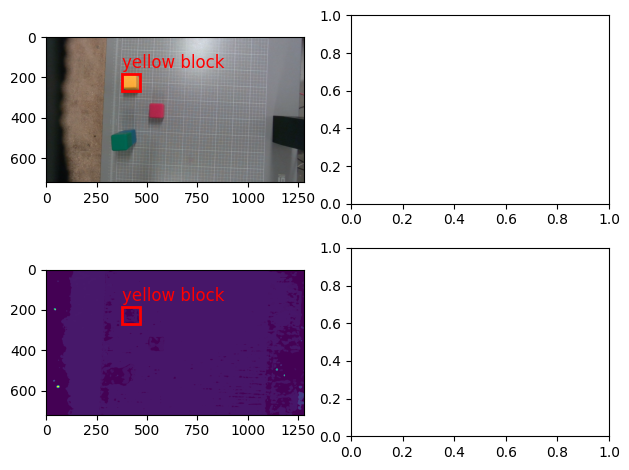

Detected 'green block' with confidence 0.31 at [[321.3888854980469, 457.4789123535156, 448.93292236328125, 567.6417236328125]]
bbox=[321.3888854980469, 457.4789123535156, 448.93292236328125, 567.6417236328125]


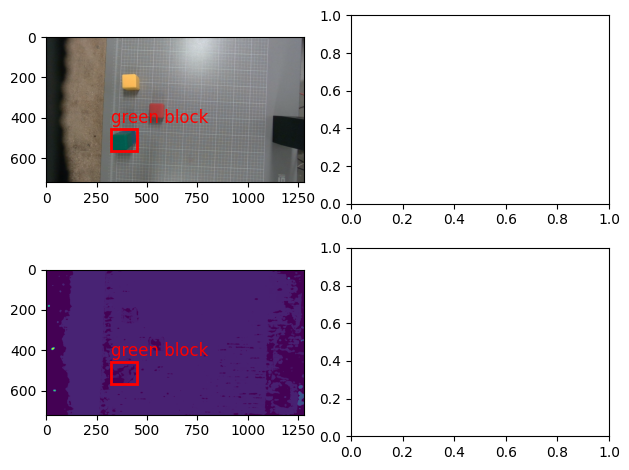

Camera Frame Coordinates of Block: X=-0.12216777354478836, Y=-0.07399741560220718, Z=0.3606700003147125

Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 
Camera Frame Coordinates of Block: X=-0.12469073385000229, Y=0.07773936539888382, Z=0.3165666460990906

Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


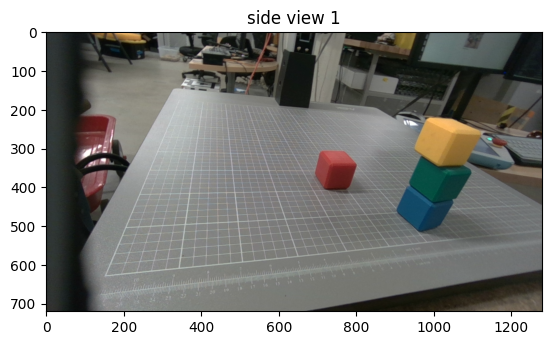

start_state={'red block': 'table', 'yellow block': 'green block', 'green block': 'blue block', 'blue block': 'table'}
end_state={'green block': 'blue block', 'yellow block': 'green block', 'red block': 'yellow block'}
prompt='\nGiven the start state:\n   red block is on table\n   yellow block is on green block\n   green block is on blue block\n   blue block is on table\n\nand desired end state:\n   green block is on blue block\n   yellow block is on green block\n   red block is on yellow block\n\nwhat is the next best move to get us closer to the end state from the start state? Your answer needs to have two parts on two seperate lines.\n   pick: *object to be picked up*\n   place: *object to put the picked object on*\n\nif there is no block to move please have\n   pick: None\n   place: None\n    '
state={
    "objects": [
        "table",
        "red block",
        "yellow block",
        "green block",
        "blue block"
    ],
    "object_relationships": [
        [
            "

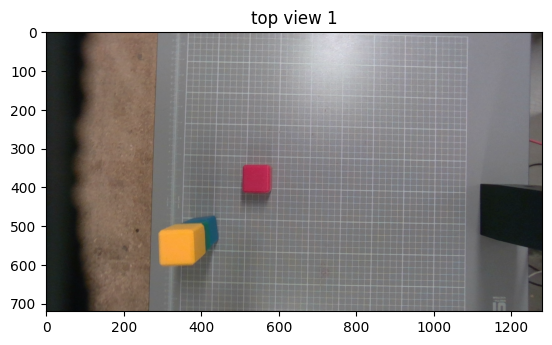

Detected 'red block' with confidence 0.23 at [[285.60015869140625, 456.68585205078125, 440.5689697265625, 583.270751953125]]
bbox=[285.60015869140625, 456.68585205078125, 440.5689697265625, 583.270751953125]


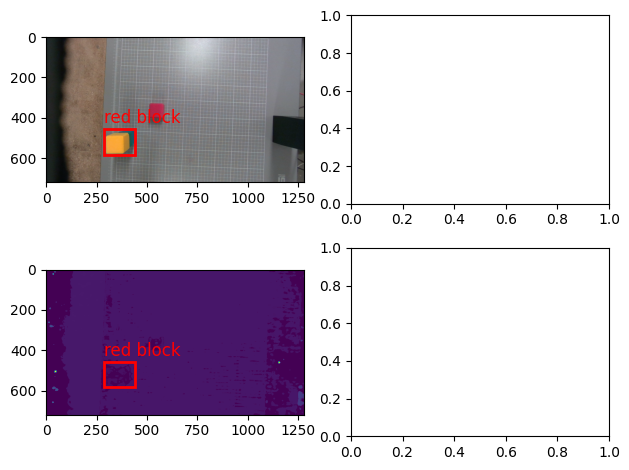

Detected 'yellow block' with confidence 0.18 at [[293.9444580078125, 477.2000732421875, 413.4947204589844, 582.0545654296875]]
bbox=[293.9444580078125, 477.2000732421875, 413.4947204589844, 582.0545654296875]


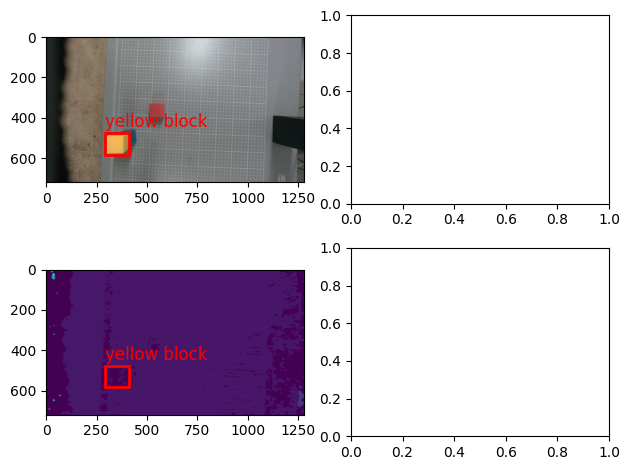

Camera Frame Coordinates of Block: X=-0.1207529827952385, Y=0.0723019689321518, Z=0.2817666530609131

Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 
Camera Frame Coordinates of Block: X=-0.12167252600193024, Y=0.0748497024178505, Z=0.2748166620731354

Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


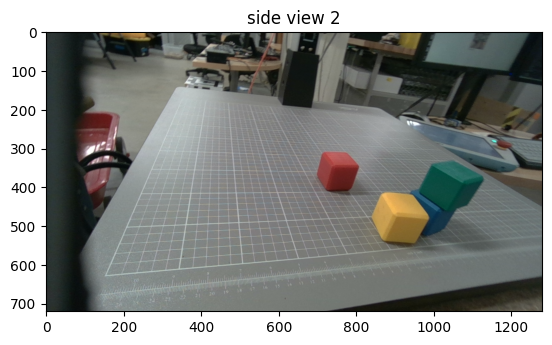

KeyboardInterrupt: 

In [ ]:
# ====== NEW =======

#tower = ["red block", "blue block", "green block", "yellow block", "purple block"]
#tower = tower.reverse()
n_attempts = 2*len(tower)
Done = 0
i = 0
top_dir = "./data_collection/"
os.makedirs(top_dir, exist_ok=True)
save_dir = create_next_directory(top_dir)
action_history = []
previous_plan = []

start_time = time.time()

#INTERPRET TASK
goto_vec(myrobot, sideview_vec)
rgb_img, depth_img = get_pictures(myrs)
plt.imshow(rgb_img)
plt.title(f"interpretation view")
plt.show()
plt.imsave(os.path.join(save_dir, "interpretationview.png"), rgb_img)

task_interpretation = get_task_interpretation(client, rgb_img)

while(not Done and i < n_attempts):
    # SET UP ITERATION DATA FOLDER
    interation_output_dir = os.path.join(save_dir, f"step {i}")
    os.makedirs(interation_output_dir, exist_ok=True)

    # GO TO SIDE POSITION, TAKE PHOTO FOR CHAT
    goto_vec(myrobot, sideview_vec)
    rgb_img, depth_img = get_pictures(myrs)
    plt.imshow(rgb_img)
    plt.title(f"side view {i}")
    plt.show()
    plt.imsave(os.path.join(interation_output_dir, "sideview.png"), rgb_img)


    # GET BOTH GPT COMPLETIONS
    (state_resp, state, state_sys_prompt, state_usr_promot), (instruction_resp, next_instruction, future_instructions, instruction_sys_prompt, instruction_usr_prompt) = get_gpt_next_instruction(client, rgb_img, tower, action_history, previous_plan)
    
    # DATA COLLECTION
    with open(os.path.join(interation_output_dir, "instruction.txt"), "w") as file:
        state_str = print_json(state, name="state")
        file.write(f"{state_str}\n")

        next_instruction_str = print_json(next_instruction, "next instruction")
        file.write(f"{next_instruction_str}\n")


        instruction_plan_str = print_json(future_instructions, name="plan")
        file.write(f"{instruction_plan_str}\n")

        file.write(f"{state_sys_prompt=}\n")
        file.write(f"{state_usr_promot=}\n")
        file.write(f"{instruction_sys_prompt=}\n")
        file.write(f"{instruction_usr_prompt=}\n")
        file.write(f"{instruction_resp=}\n")
        print(f"{instruction_resp=}")
        print(f"{instruction_usr_prompt=}")
    
    action_history.append(next_instruction)
    previous_plan = future_instructions
    Done = int(next_instruction["done"]) # update finished flag

    if Done:
        break

    pick_str= next_instruction['pick']
    place_str= next_instruction['place']

    # GO TO TOP POSITION
    goto_vec(myrobot, topview_vec)

    # TAKE PHOTOS
    rgb_img, depth_img = get_pictures(myrs)
    plt.imshow(rgb_img)
    plt.title(f"top view {i}")
    plt.show()
    plt.imsave(os.path.join(interation_output_dir, "topview.png"), rgb_img)

    # GET OBJECT LOCATION AND DEPTH
    pick_obs, place_obs = topview_pick_place_Observations(myrobot, myrs, pick_str, place_str, display=True)

    # EXECUTE PICK AND PLACE
    pick(myrobot, pick_obs)
    place(myrobot, place_obs)
    i += 1

print(f"Total time taken: {time.time() - start_time}")